In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import wfdb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import neurokit2 as nk
from scipy.signal import resample, medfilt
import pywt
import pickle
import time
import os
import csv 
import mne
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import neurokit2 as nk
from zoneinfo import ZoneInfo

In [2]:
def preprocessing_data(data):
    band_passed_ecg =  nk.signal_filter(data, sampling_rate=360, lowcut=0.5, highcut=100, method='butterworth_zi', order = 2)
    emg = moving_average(band_passed_ecg, window_size=10)
    # Step 4: Downsample the filtered ECG signal 
    downsampled_ecg = nk.signal_resample(emg, sampling_rate=360, desired_sampling_rate=100)
    return downsampled_ecg

In [3]:
def load_record(record_id, seq_len=1000, stride=1000):
    record_name = str(record_id)
    if not os.path.exists(f"mit_bih/{record_name}.dat"):
        wfdb.dl_database('mitdb', './', records=[record_name])
    record = wfdb.rdrecord('mit_bih/' + record_name)
    
    #Extract each channel
    signal_data = record.p_signal
    ch1 = preprocessing_data(signal_data[:, 0]).reshape(-1, 1)
    ch2 = preprocessing_data(signal_data[:, 1]).reshape(-1, 1)

    #Scale the signal
    scaler1 = MinMaxScaler(feature_range=(-0.5, 0.5))
    scaler2 = MinMaxScaler(feature_range=(-0.5, 0.5))
    ch1_scale = scaler1.fit_transform(ch1)
    ch2_scale = scaler2.fit_transform(ch2)

    
    # Create sequences using sliding window
    seq_ch1 = [ch1_scale[i:i+seq_len] for i in range(0, len(ch1_scale)-seq_len+1, stride)]
    seq_ch2 = [ch2_scale[i:i+seq_len] for i in range(0, len(ch2_scale)-seq_len+1, stride)]
    seq_ch1.extend(seq_ch2)
    return seq_ch1

def load_multiple_records(record_ranges, seq_len=1000, stride_len=100):
    all_data = []

    for start, end in tqdm(record_ranges):
        for record_id in range(start, end + 1):
            record_data = load_record(record_id, seq_len, stride_len)
            all_data.extend(record_data)
    # Save to pkl
    with open('database.pkl', 'wb') as f:
        pickle.dump(all_data, f)
    
    return all_data

In [4]:
def downsample(data, original_rate, target_rate):
    num_samples = int(len(data) * target_rate / original_rate)
    return resample(data, num_samples)

def calculate_l1(predictions, targets):
    l1_norm = torch.norm(predictions-targets, p=1)
    l1_sum = torch.sum(torch.abs(targets))
    accuracy = 100 * (1 - (l1_norm / l1_sum))
    return accuracy

def calculate_l2(predictions, targets):
    l2_norm = torch.norm(predictions - targets, p=2)
    l2_sum = torch.norm(targets, p=2)
    accuracy = 100 * (1 - (l2_norm / l2_sum))
    return accuracy

def calculate_MAPE(predictions, targets):
    mape = torch.mean(torch.abs((targets - predictions) / (targets)))
    return mape

In [5]:
def fixed_position_mask_peaks(rpeaks, seq, mask_length, num_peaks_to_mask):
    mask = np.zeros_like(seq, dtype=bool)  # Create a mask with the same length as seq, initially all False

    if len(rpeaks) > 0:  # If there are detected peaks
        # Randomly select 'num_peaks_to_mask' peaks from rpeaks
        selected_peaks = rpeaks[1:2*num_peaks_to_mask + 1: 2]

        for peak in selected_peaks:
            mask_half = mask_length // 2
            start = int(max(0, peak - mask_half))
            end = int(min(len(seq), peak + mask_half))
            mask[start:end] = True
    
    return mask

def fixed_position_mask_P_T(rpeaks, seq, mask_length, num_peaks_to_mask):
    mask = np.zeros_like(seq, dtype=bool)  # Create a mask with the same length as seq, initially all False

    if len(rpeaks) > 0:  # If there are detected peaks
        # Randomly select 'num_peaks_to_mask' peaks from rpeaks
        selected_peaks = rpeaks[1:2*num_peaks_to_mask + 1: 2]

        for peak in selected_peaks:
            P_start = int(max(0, peak - 15 - mask_length))
            P_end = int(max(0, peak + 15))
            T_start = int(max(0, peak + 15))
            T_end = int(min(0, peak + 15 + mask_length))            
            mask[P_start:P_end] = True
            mask[T_start:T_end] = True
    return mask

def fixed_position_mask_peaks_int(rpeaks, seq, mask_length, num_peaks_to_mask):
    mask = np.ones_like(seq, dtype=float)  # Create a mask with the same length as seq, initially all False

    if len(rpeaks) > 0:  # If there are detected peaks
        # Randomly select 'num_peaks_to_mask' peaks from rpeaks
        selected_peaks = rpeaks[1:2*num_peaks_to_mask + 1: 2]

        for peak in selected_peaks:
            mask_half = mask_length // 2
            start = int(max(0, peak - mask_half))
            end = int(min(len(seq), peak + mask_half))
            mask[start:end] = 0
    
    return mask

In [6]:
import torch
from torch.utils.data import Dataset
import numpy as np
import neurokit2 as nk

class ECGDataset(Dataset):
    def __init__(self, data, seq_len=1000, mask_length=30, target_rate=100, num_peaks_to_mask=1):
        """
        Args:
            data (np.array): Full ECG signal data.
            seq_len (int): Length of each sequence before downsampling.
            mask_length (int): Length of masking window around the first R-peak.
            target_rate (int): Target sampling rate after downsampling.
            augment (bool): Whether to apply data augmentation.
        """
        self.data = data
        self.seq_len = seq_len
        self.mask_length = mask_length
        self.target_rate = target_rate
        self.num_peaks_to_mask = num_peaks_to_mask

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq = self.data[idx].flatten()
        # Detect R-peaks
        rpeaks = nk.ecg_findpeaks(seq, sampling_rate=self.target_rate)['ECG_R_Peaks']

        # Create masking
        mask_r_peak = fixed_position_mask_peaks(rpeaks, seq, self.mask_length, self.num_peaks_to_mask)
        mask_p_t_peak = fixed_position_mask_P_T(rpeaks, seq, 15, self.num_peaks_to_mask)

      #  masked_seq = seq.copy()
        # masked_seq[mask] = 0  # Apply masking

        return (
            torch.tensor(seq, dtype=torch.float32),
            torch.tensor(mask_r_peak, dtype=torch.bool),
            torch.tensor(mask_p_t_peak, dtype=torch.bool)
        )


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MaskingLayer(nn.Module):
    def __init__(self):
        super(MaskingLayer, self).__init__()
        
    def forward(self, seq, mask):
        seq = seq.clone()   # avoid in-place ops on computation graph
        seq[mask] = 0
        return seq


class Encoder1D_Mask(nn.Module):
    class Conv_Block(nn.Module):
        def __init__(self, embed_dim=32, hidden_dim=64):
            super().__init__()
            self.conv1 = nn.Conv1d(1, embed_dim, kernel_size=3, stride=1, padding=1)
            self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

            self.conv2 = nn.Conv1d(embed_dim, embed_dim * 2, kernel_size=3, stride=1, padding=1)
            self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

            self.conv3 = nn.Conv1d(embed_dim * 2, hidden_dim, kernel_size=3, stride=1, padding=1)

        def forward(self, x):
            # Input: (B, L) → (B, 1, L)
            x = x.unsqueeze(1)
            
            x = F.leaky_relu(self.conv1(x), negative_slope=0.01)
            x = self.pool1(x)
            x = F.leaky_relu(self.conv2(x), negative_slope=0.01)
            x = self.pool2(x)
            x = F.leaky_relu(self.conv3(x), negative_slope=0.01)
            return x

    def __init__(self, embed_dim=32, hidden_dim=64, lstm_hidden_dim=128):
        super().__init__()
        self.mask_peaks = MaskingLayer()
        self.QRS_Conv_Block = self.Conv_Block(embed_dim, hidden_dim)
        self.P_T_Conv_Block = self.Conv_Block(embed_dim, hidden_dim)
        self.bilstm = nn.LSTM(hidden_dim * 2, lstm_hidden_dim,
                              bidirectional=True, batch_first=True)

    def forward(self, x, mask_qrs, mask_pt):
        # Apply masking
        qrs_x = self.mask_peaks(x, mask_qrs)
        pt_x = self.mask_peaks(x, mask_pt)

        # Encode each branch
        qrs_x = self.QRS_Conv_Block(qrs_x)
        pt_x = self.P_T_Conv_Block(pt_x)

        # Concatenate features along channels
        x = torch.cat([qrs_x, pt_x], dim=1)  # (B, hidden_dim*2, L/4)

        # BiLSTM expects (B, L, C)
        x = x.permute(0, 2, 1)
        x, _ = self.bilstm(x)
        x = x.permute(0, 2, 1)  # (B, 2*lstm_hidden_dim, L/4)
        
        return x


class Decoder1D(nn.Module):
    def __init__(self, embed_dim=32, hidden_dim=64, lstm_hidden_dim=128):
        super().__init__()
        self.deconv1 = nn.Conv1d(lstm_hidden_dim * 2, embed_dim * 2,
                                 kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.Conv1d(embed_dim * 2, embed_dim,
                                 kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.Conv1d(embed_dim, 1,
                                 kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = F.leaky_relu(self.deconv1(x), negative_slope=0.01)
        x = F.interpolate(x, scale_factor=2, mode='linear', align_corners=True)

        x = F.leaky_relu(self.deconv2(x), negative_slope=0.01)
        x = F.interpolate(x, scale_factor=2, mode='linear', align_corners=True)

        x = self.deconv3(x)  # (B, 1, L)
        return x  # keep (B, 1, L)


class MAE1D_Mask(nn.Module):
    def __init__(self, embed_dim=32, hidden_dim=64, lstm_hidden_dim=128):
        super().__init__()
        self.encoder = Encoder1D_Mask(embed_dim, hidden_dim, lstm_hidden_dim)
        self.decoder = Decoder1D(embed_dim, hidden_dim, lstm_hidden_dim)

    def forward(self, x, mask_qrs, mask_pt):
        x = self.encoder(x, mask_qrs, mask_pt)
        x = self.decoder(x)
        return x.squeeze(1)


In [8]:
# Data preparation
def prepare_data(data, seq_len, num_rpeaks, mask_len, batch_size=128):
    dataset = ECGDataset(data, seq_len, mask_length = mask_len, num_peaks_to_mask = num_rpeaks)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [9]:
class Trainer:
    def __init__(self, model, criterion, optimizer, seq_len=5000, num_rpeak=1, log_dir=None, masking_length = 30,scale = 'minmax_0_5',test_case = True):
        self.seq_len = seq_len
        self.num_rpeak = num_rpeak
        self.mask_len = masking_length
        self.scale = scale
        self.device = ( "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
        self.model = model.to(self.device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        self.log_dir = log_dir
        self.test_case = test_case
        self.cur_time = datetime.now(ZoneInfo("Australia/Sydney")).strftime("%H%M_%d%m%Y")
        if self.log_dir is None:
            self.log_dir = f'runs/seq{seq_len}_rpeak{num_rpeak}_{self.cur_time}'
        if self.test_case == False:
            self.writer = SummaryWriter(log_dir=self.log_dir)

    def run(self, train_loader, val_loader, test_loader, epochs=100, patience = 10):
        best_val_loss = float('inf')
        patience_counter = 0
        
        for epoch in range(epochs):
            self.model.train()
            train_loss = 0.0
            for original_seq, mask_qrs, mask_pt in train_loader:
                original_seq, mask_qrs,mask_pt = original_seq.to(self.device), mask_qrs.to(self.device), mask_pt.to(self.device)

                self.optimizer.zero_grad()
                reconstructed = self.model(original_seq, mask_qrs, mask_pt)

                loss_masked = self.criterion(reconstructed[mask_qrs + mask_pt], original_seq[mask_qrs + mask_pt])
                # full reconstruction loss to preserve unmasked regions (small weight)
                loss_full = self.criterion(reconstructed, original_seq)
                
                # combine: favor masked loss but still penalize drifting on unmasked
                alpha = 1.0   # weight for masked-target objective
                beta  = 0.1  # small weight for full-signal reconstruction
                loss = alpha * loss_masked + beta * loss_full


                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()

            avg_train_loss = train_loss / len(train_loader)
            self.train_losses.append(avg_train_loss)

            avg_val_loss, avg_l1, avg_l2, avg_MAPE = self.evaluate(epoch=epoch, data_loader = val_loader)
            self.val_losses.append(avg_val_loss)

            print(f"Epoch {epoch}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
                  f"L1 Accuracy: {avg_l1:.2f}, L2 Accuracy: {avg_l2:.2f}, MAPE Accuracy: {avg_MAPE:.2f}")
            if self.test_case == False:
                self.writer.add_scalar("Loss/Train", avg_train_loss, epoch)
                self.writer.add_scalar("Loss/Validation", avg_val_loss, epoch)
                self.writer.add_scalar("Accuracy/L1", avg_l1, epoch)
                self.writer.add_scalar("Accuracy/L2", avg_l2, epoch)
                self.writer.add_scalar("Accuracy/MAPE", avg_MAPE, epoch)

            if epoch % 10 == 0:
                print(f"{self.log_dir}/model_{self.seq_len}_{self.num_rpeak}_{self.cur_time}.pth")
                if self.test_case == False:
                    print("Saving the best model checkpoint...")
                    torch.save(self.model.state_dict(), f"{self.log_dir}/model_{self.seq_len}_{self.num_rpeak}_{self.cur_time}.pth")

        self.writer.close()
        if test_loader is None:
            self.final_evaluation(val_loader)
        else: 
            self.final_evaluation(test_loader)
            
    def evaluate(self, data_loader, epoch= None):
        self.model.eval()
        val_loss = 0.0
        l1_accuracy = 0.0
        l2_accuracy = 0.0
        MAPE_accuracy = 0.0

        with torch.no_grad():
            for original_seq, mask_qrs, mask_pt in data_loader:
                original_seq, mask_qrs,mask_pt = original_seq.to(self.device), mask_qrs.to(self.device), mask_pt.to(self.device)
                reconstructed = self.model(original_seq, mask_qrs, mask_pt)
                
                loss_qrs = self.criterion(reconstructed[mask_qrs], original_seq[mask_qrs])
                loss_pt = self.criterion(reconstructed[mask_pt], original_seq[mask_pt])
                loss_masked = 0.7 * loss_qrs + 0.3 * loss_pt
                # full reconstruction loss to preserve unmasked regions (small weight)
                loss_full = self.criterion(reconstructed, original_seq)
                
                # combine: favor masked loss but still penalize drifting on unmasked
                alpha = 1.0   # weight for masked-target objective
                beta  = 0.1  # small weight for full-signal reconstruction
                loss = alpha * loss_masked + beta * loss_full
                
                val_loss += loss.item()
                l1_accuracy += calculate_l1(reconstructed[mask_qrs+mask_pt], original_seq[mask_qrs+mask_pt])
                l2_accuracy += calculate_l2(reconstructed[mask_qrs+mask_pt], original_seq[mask_qrs+mask_pt])
                MAPE_accuracy += calculate_MAPE(reconstructed[mask_qrs+mask_pt], original_seq[mask_qrs+mask_pt])

        avg_val_loss = val_loss / len(data_loader)
        avg_l1 = l1_accuracy / len(data_loader)
        avg_l2 = l2_accuracy / len(data_loader)
        avg_MAPE = MAPE_accuracy / len(data_loader)

        if epoch is None:
            print(f"\nValidation Loss: {avg_val_loss:.4f}")
            print(f"L1 Accuracy: {avg_l1:.4f}")
            print(f"L2 Accuracy: {avg_l2:.4f}")
            print(f"MAPE Accuracy: {avg_MAPE:.2f}%")
        return avg_val_loss, avg_l1, avg_l2, avg_MAPE
        
    def plot_predictions_with_residuals(self, data_loader, sample_len = None, num_samples=2 ):
        self.model.eval()
        all_actual, all_predicted, all_masks = [], [], []
        if sample_len is None:
            sample_len = self.seq_len
        
        with torch.no_grad():
            for original_seq, mask_qrs, mask_pt in data_loader:
                original_seq, mask_qrs,mask_pt = original_seq.to(self.device), mask_qrs.to(self.device), mask_pt.to(self.device)
                reconstructed = self.model(original_seq, mask_qrs, mask_pt)
                mask = mask_qrs + mask_pt
                all_actual.extend(original_seq.cpu().numpy())  # original (unmasked) ECG
                all_predicted.extend(reconstructed.cpu().numpy())  # predictions
                all_masks.extend(mask.cpu().numpy()) # Masked regions
     
                break  # Take only one batch for plotting
        
        # Flatten the lists for metric calculation
        all_actual_flat = np.concatenate(all_actual)
        all_predicted_flat = np.concatenate(all_predicted)
        
        # Calculate metrics
        mse = mean_squared_error(all_actual_flat, all_predicted_flat)
        mae = mean_absolute_error(all_actual_flat, all_predicted_flat)
        r2 = r2_score(all_actual_flat, all_predicted_flat)
    
        print(f"Mean Squared Error (MSE): {mse:.4f}")
        print(f"Mean Absolute Error (MAE): {mae:.4f}")
        print(f"R-squared (R²): {r2:.4f}")
        
        # Visualize predictions vs. actual data with residuals
        plt.figure(figsize=(15, num_samples * 5))
        for i in range(min(num_samples, len(all_actual))):
            original = all_actual[i]
            predicted = all_predicted[i]
            mask = all_masks[i]
    
            # Plot predictions vs actual data
            plt.subplot(num_samples, 2, i * 2 + 1)
            plt.plot(original[:sample_len], label="Original", color="blue", alpha=0.7)
            plt.plot(predicted[:sample_len], label="Predicted", color="orange", alpha=0.7)
    
            # Highlight masked regions
            masked_indices = np.where(mask)[0]
            plt.scatter(masked_indices, original[masked_indices], color="red", label="Masked Regions", alpha=0.7)
    
            plt.title(f"Sample {i + 1} - Predictions")
            plt.legend()
    
            # Compute and plot residuals
            residuals = np.array(original) - np.array(predicted)
            plt.subplot(num_samples, 2, i * 2 + 2)
            plt.plot(residuals[:sample_len], label="Residuals", color="green")
            plt.axhline(0, color="black", linestyle="--")
            plt.title(f"Sample {i + 1} - Residuals")
            plt.legend()
    
        plt.tight_layout()
        plt.show()

    def plot_loss_curves(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label="Train Loss", marker='o')
        plt.plot(self.val_losses, label="Validation Loss", marker='o')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss Curves")
        plt.legend()
        plt.grid()
        plt.show()
        
    def final_evaluation(self, data_loader):
        avg_val_loss, avg_l1, avg_l2, avg_MAPE = self.evaluate(data_loader, epoch= None)
        with open('runs/Model_Running.csv', 'a') as f_object:
            writer_object = csv.writer(f_object)
            writer_object.writerow([f'model_{self.seq_len}_{self.num_rpeak}_{self.cur_time}.pth', avg_l1.cpu().numpy(), avg_l2.cpu().numpy(), avg_MAPE.cpu().numpy(), self.seq_len, self.num_rpeak, self.mask_len, self.scale])
            f_object.close()  
        self.plot_predictions_with_residuals(data_loader, sample_len = 1000)
        self.plot_loss_curves()

In [10]:
def plot_some_sample(data_loader, device, num_samples=5):
    all_actual, all_masks = [], []
    with torch.no_grad():
        for masked_seq, original_seq, mask in data_loader:
            all_actual.extend(original_seq)  # original (unmasked) ECG
            all_masks.extend(mask) # Masked regions
            break
            
    plt.figure(figsize=(15, num_samples * 5))
    for i in range(min(num_samples, len(all_actual))):
        original = all_actual[i]
        mask = all_masks[i]

        # Plot predictions vs actual data
        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.plot(original, label="Original", color="blue", alpha=0.7)

        # Highlight masked regions
        masked_indices = np.where(mask)[0]
        plt.scatter(masked_indices, original[masked_indices], color="red", label="Masked Regions", alpha=0.7)

        plt.title(f"Sample {i + 1} - Predictions")
        plt.legend()    

def plot_ecg_sample_no_mask(data, num_samples=2):
    # Visualize predictions vs. actual data with residuals
    fig, ax = plt.subplots(1, num_samples, figsize = (16,9))
    ax = ax.flatten()
    for i in range(0, num_samples):
        # Plot predictions vs actual data
        ax[i].plot(data[i], label="Original", color="blue", alpha=0.7)
    plt.tight_layout()
    plt.show()

Working with data


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.89it/s]


Training the model with 3 R peaks
Preparing the data
Training the model
Epoch 0, Train Loss: 0.0092, Val Loss: 0.0067, L1 Accuracy: 63.17, L2 Accuracy: 49.85, MAPE Accuracy: 3.40
runs/seq500_rpeak3_0213_03092025/model_500_3_0213_03092025.pth
Saving the best model checkpoint...
Epoch 1, Train Loss: 0.0044, Val Loss: 0.0048, L1 Accuracy: 69.86, L2 Accuracy: 57.33, MAPE Accuracy: 2.22
Epoch 2, Train Loss: 0.0033, Val Loss: 0.0038, L1 Accuracy: 72.52, L2 Accuracy: 62.02, MAPE Accuracy: 1.74
Epoch 3, Train Loss: 0.0027, Val Loss: 0.0032, L1 Accuracy: 74.97, L2 Accuracy: 65.01, MAPE Accuracy: 2.34
Epoch 4, Train Loss: 0.0023, Val Loss: 0.0030, L1 Accuracy: 74.66, L2 Accuracy: 66.28, MAPE Accuracy: 1.69
Epoch 5, Train Loss: 0.0020, Val Loss: 0.0025, L1 Accuracy: 77.58, L2 Accuracy: 68.98, MAPE Accuracy: 1.77
Epoch 6, Train Loss: 0.0018, Val Loss: 0.0021, L1 Accuracy: 79.76, L2 Accuracy: 71.49, MAPE Accuracy: 1.49
Epoch 7, Train Loss: 0.0016, Val Loss: 0.0019, L1 Accuracy: 81.11, L2 Accuracy: 

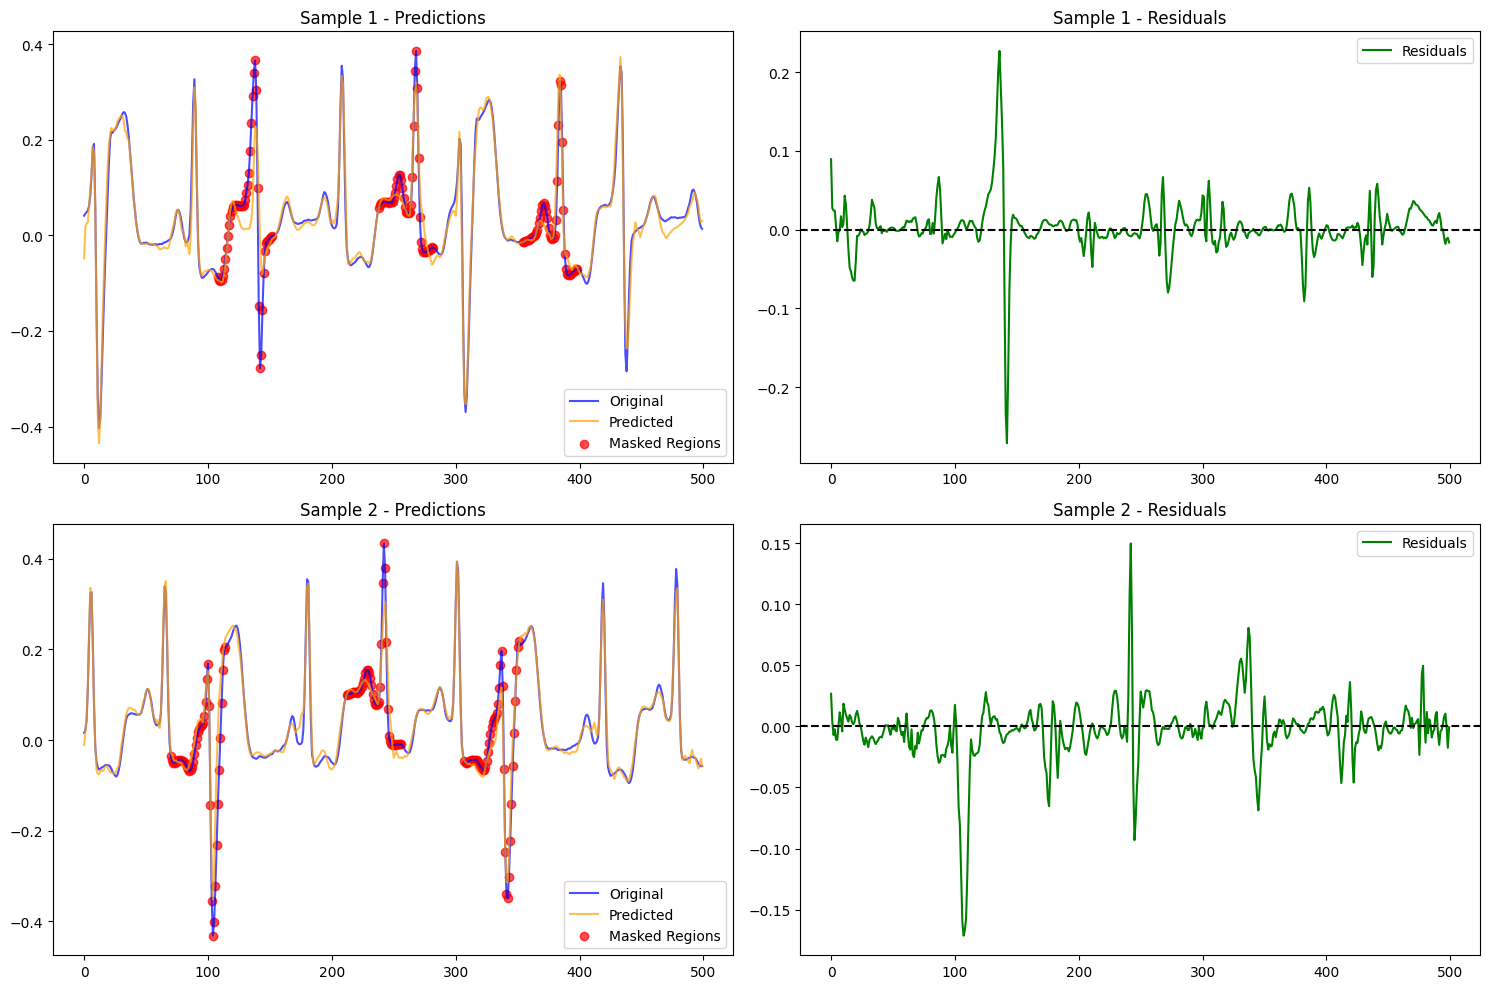

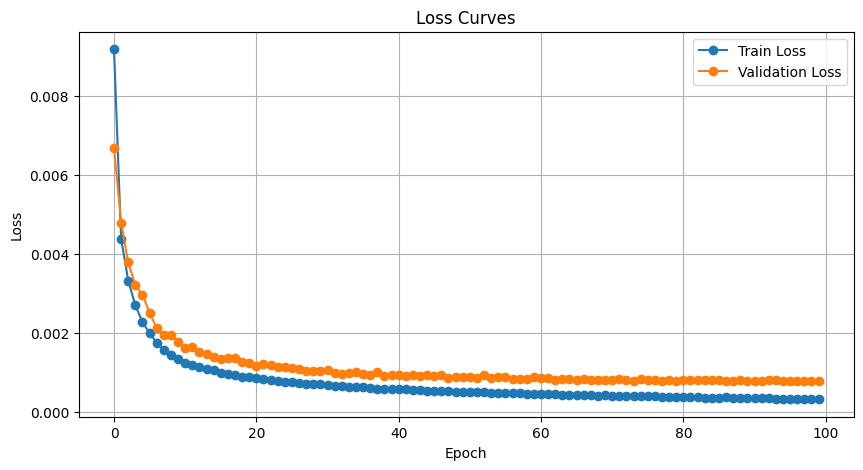

In [45]:
record_ranges = [(100,109),(111, 119),(121,124),(200,203),(205,205),(207,210),(212,215),(217,217),(219,223),(228,228),(230,232)]
print("Working with data")
seq_len = 500
stride = 500
mask_length = 30
data = np.array(load_multiple_records(record_ranges, seq_len, stride))
test_data = load_multiple_records([(233,234)], seq_len, stride)

for num in [3]: 
    print("="*20)
    print(f"Training the model with {num} R peaks")
    print("="*20)
    
    print("Preparing the data")
    train_loader, val_loader = prepare_data(data,num_rpeaks = num, seq_len=seq_len, mask_len = mask_length)
    test_dataset = ECGDataset(test_data, seq_len, num_peaks_to_mask = num)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    
    print("Training the model")
    criterion = nn.MSELoss()
    mae_model = MAE1D_Mask()
    optimizer = optim.Adam(mae_model.parameters(), lr=0.001)    

    model_trainer = Trainer(model = mae_model, 
                            criterion = criterion, optimizer = optimizer,  
                            seq_len=seq_len, masking_length = mask_length, num_rpeak=num, 
                            scale = 'Minmax_05',
                            test_case = False)
    model_trainer.run(train_loader, val_loader, test_loader, epochs = 100)

# Fine- truning

In [11]:
from torch.utils.data import DataLoader, TensorDataset
from wesad_processing import *
WIN_SIZE = 10
def load_wesad_dataset(root_dir, test_subject):
    folder_ls = os.listdir(root_dir)
    for i in folder_ls:
        if i == ".ipynb_checkpoints" or i == '.DS_Store':
            folder_ls.remove(i)
    
    valid_ls = test_subject
    # Create the train list by excluding test_ls
    train_ls = [subject for subject in folder_ls if subject not in valid_ls]
    print("==========Loading Training set============")
    X_train, y_train = load_process_extract_ls(root_dir, train_ls,700, WIN_SIZE,WIN_SIZE,True)
    print(X_train.shape)
    print("==========Loading Testing set============")
    X_test, y_test = load_process_extract_ls(root_dir,valid_ls,700, WIN_SIZE, WIN_SIZE,False)
    return X_train, X_test, y_train, y_test
    
class ECGClassificationDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X  # shape: [N, L]
        self.Y = Y  # shape: [N]
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        seq = self.X[idx].flatten()
        return torch.tensor(seq, dtype=torch.float32).unsqueeze(0), torch.tensor(self.Y[idx], dtype=torch.long)

In [17]:
class DownstreamClassifier(nn.Module):
    def __init__(self, encoder, num_classes=2):
        super(DownstreamClassifier, self).__init__()
        self.encoder = encoder

        # Freeze encoder parameters
        for param in self.encoder.parameters():
            param.requires_grad = False
        
        # Classifier head after GAP
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.LeakyReLU(negative_slope = 0.01),
            nn.Linear(128, num_classes)
        )

    def forward(self, x, mask=None):
        # If no mask given, create a zero-mask (no masking)
        if mask is None:
            mask = torch.zeros_like(x, dtype=torch.bool)

        x = x.squeeze(1)         # (B, L)
        mask = mask.squeeze(1)   # (B, L)

        # Pass through encoder
        z = self.encoder(x, mask, mask)  # -> (B, C, L)

        # Global Average Pooling over sequence dimension
        z = F.adaptive_avg_pool1d(z, 1)  # -> (B, C, 1)
        z = z.squeeze(-1)                # -> (B, C)

        logits = self.classifier(z)      # -> (B, num_classes)
        return logits


In [18]:
def evaluate(model, dataloader, criterion, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam([
        {"params": model.encoder.parameters(), "lr": 1e-8},     # smaller LR for encoder
        {"params": model.classifier.parameters(), "lr": 1e-3}   # larger LR for classifier
    ], weight_decay=1e-4)
    # --- Validation ---
    model.eval()
    
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for x_val, y_val in dataloader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            
            preds = torch.argmax(outputs, dim=1)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(y_val.cpu().numpy())
    
    prec_temp = precision_score(all_val_labels, all_val_preds)
    rec_temp = recall_score(all_val_labels, all_val_preds)
    f1_temp = f1_score(all_val_labels, all_val_preds,average='macro')
    acc_temp = accuracy_score(all_val_labels, all_val_preds)
    
    return prec_temp, rec_temp, f1_temp, acc_temp


In [19]:
def train_evaluate_downstream_classifier(
    model,
    train_loader,
    val_loader,
    test_loader,
    num_epochs=60,
    device = 'cuda'
):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam([
        {"params": model.encoder.parameters(), "lr": 1e-8},     # smaller LR for encoder
        {"params": model.classifier.parameters(), "lr": 1e-3}   # larger LR for classifier
    ], weight_decay=1e-4)
    model.to(device)
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        all_train_preds = []
        all_train_labels = []

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            outputs = model(x)
            loss = criterion(outputs, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(y.cpu().numpy())

        train_accuracy = accuracy_score(all_train_labels, all_train_preds)
        train_f1_macro = f1_score(all_train_labels, all_train_preds, average='macro')

        # --- Validation ---
        model.eval()
        val_loss = 0.0
        all_val_preds = []
        all_val_labels = []

        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                outputs = model(x_val)
                loss = criterion(outputs, y_val)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(y_val.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = accuracy_score(all_val_labels, all_val_preds)
        val_f1_macro = f1_score(all_val_labels, all_val_preds, average='macro')
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch}: "
              f"Train Loss = {total_loss/len(train_loader):.4f}, "
              f"Train Acc = {train_accuracy:.4f}, "
              f"Train F1 = {train_f1_macro:.4f} | "
              f"Val Loss = {avg_val_loss:.4f}, "
              f"Val Acc = {val_accuracy:.4f}, "
              f"Val F1 = {val_f1_macro:.4f}")
        
    prec, rec, f1, acc = evaluate(model, test_loader, criterion, device)
    return prec, rec, f1, acc

In [20]:

def loso_training(root_dir, sample_rate, test_size, filename, load_file):
    prec, rec, acc, f1 = [], [], [], []
    folder_ls = [f for f in os.listdir(root_dir) if f not in (".ipynb_checkpoints", ".DS_Store")]
    start_index = np.arange(0, len(folder_ls) - test_size + 1, test_size)

    # Load pretrained model once
    auto_model = MAE1D_Mask()
    auto_model.load_state_dict(torch.load(
        'runs/seq500_rpeak3_0213_03092025/model_500_3_0213_03092025.pth', 
        weights_only=True
    ))
    encoder = auto_model.encoder

    for start in start_index:
        subj = folder_ls[start:start + test_size]
        print(f"***** Loop {start}: {subj} *****")

        # Load dataset
        X_train, X_test, y_train, y_test = load_wesad_dataset(root_dir, subj)
        train_dataset = ECGClassificationDataset(X_train, y_train)
        test_dataset = ECGClassificationDataset(X_test, y_test)

        # Split train/val
        train_size = int(0.8 * len(train_dataset))
        val_size = len(train_dataset) - train_size
        train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

        loaders = {
            'train': DataLoader(train_dataset, batch_size=128, shuffle=True),
            'val': DataLoader(val_dataset, batch_size=128, shuffle=False),
            'test': DataLoader(test_dataset, batch_size=128, shuffle=False)
        }

        # Train and evaluate downstream classifier
        model = DownstreamClassifier(encoder)
        prec_, rec_, f1_, acc_ = train_evaluate_downstream_classifier(
            model, loaders['train'], loaders['val'], loaders['test'], num_epochs=100, device='cuda'
        )
        prec.append(prec_); rec.append(rec_); f1.append(f1_); acc.append(acc_)
        print([start, acc_, f1_, rec_, prec_])

        # Save iteration results
        with open(filename, 'a', newline='') as f:
            csv.writer(f).writerow([start, acc_, f1_, rec_, prec_, subj])

    # Save mean results
    with open(filename, 'a', newline='') as f:
        csv.writer(f).writerow([np.mean(acc), np.mean(f1), np.mean(prec), np.mean(rec)])

    print(f"Accuracy: {np.mean(acc)}, F1: {np.mean(f1)}, Precision: {np.mean(prec)}, Recall: {np.mean(rec)}")
    return acc, f1, rec, prec


In [21]:
accuracy_ls, f1_score_ls, recall_score_ls, precision_score_ls = loso_training("/home/van/NamQuang/Dataset/WESAD_LOSO", 700,1,'test_loso.csv',  False)

***** Loop 0: ['S16'] *****
==========Loading Training set============
Working with: /home/van/NamQuang/Dataset/WESAD_LOSO/S9/S9.pkl
Working with: /home/van/NamQuang/Dataset/WESAD_LOSO/S13/S13.pkl
Working with: /home/van/NamQuang/Dataset/WESAD_LOSO/S8/S8.pkl
Working with: /home/van/NamQuang/Dataset/WESAD_LOSO/S4/S4.pkl
Working with: /home/van/NamQuang/Dataset/WESAD_LOSO/S11/S11.pkl
Working with: /home/van/NamQuang/Dataset/WESAD_LOSO/S15/S15.pkl
Working with: /home/van/NamQuang/Dataset/WESAD_LOSO/S3/S3.pkl
Working with: /home/van/NamQuang/Dataset/WESAD_LOSO/S2/S2.pkl
Working with: /home/van/NamQuang/Dataset/WESAD_LOSO/S6/S6.pkl
Working with: /home/van/NamQuang/Dataset/WESAD_LOSO/S7/S7.pkl
Working with: /home/van/NamQuang/Dataset/WESAD_LOSO/S14/S14.pkl
Working with: /home/van/NamQuang/Dataset/WESAD_LOSO/S10/S10.pkl
Working with: /home/van/NamQuang/Dataset/WESAD_LOSO/S5/S5.pkl
Working with: /home/van/NamQuang/Dataset/WESAD_LOSO/S17/S17.pkl
(4123, 1000, 1)
==========Loading Testing set====

KeyboardInterrupt: 